In [2]:
import numpy as np
import matplotlib.pyplot as plt

from units import *
from profiles import Profiles

%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

# A toy simulation

In [4]:
class AstrometricSim:
    def __init__(self, theta_x_lims=[-1.6, 1.6], theta_y_lims=[-0.9, 0.9]):
        """
        Class to create animations of astrometric weak lensing. For demo and not science!
        :param theta_x_lims: x-axis coordinate limits [x_min, x_max] in arcsecs
        :param theta_y_lims: y-axis coordinate limits [y_min, y_max] in arcsecs
        """

        self.theta_x_lims = theta_x_lims
        self.theta_y_lims = theta_y_lims

        # Area of sky region
        self.roi_area = (self.theta_x_lims[1] - self.theta_x_lims[0]) * \
                        (self.theta_y_lims[1] - self.theta_y_lims[0])

    def animation(self, pos_l, M_l, R_l, v_l, D_l,
                  n_sources_fix=True,
                  # Source properties
                  std_mu_s=1e-6,
                  n_dens=20, source_pos="random"
                  ):
        """
        :param pos_l: tuple of lens positions, format [[x_1, y_1], [x_2, y_2]...]
        :param M_l: tuple of lens masses
        :param R_l: tuple of lens sizes (Gaussian lens)
        :param v_l: tuple of lens velocities
        :param D_l: tuple of distances of lenses
        :param n_dens: density of sources (per arcsecs^2); default 20
        :param source_pos: must be one of ["uniform", "random"]; default "random"
        """

        # Get total number of sources in sky region
        
        if n_sources_fix:
            self.n_total = np.floor(n_dens * self.roi_area).astype(np.int32)
        else:
            self.n_total = np.random.poisson(n_dens * self.roi_area)
        
        # Source velocities
        self.mu_s_intrinsic = np.random.normal(loc=0, scale=std_mu_s, size=(ds.n_total, 2))
        
        # Set source positions

        # Random positions + custom if specified
        if source_pos == "random":

            # Initial source property array
            self.sources = np.zeros(self.n_total, dtype=[("theta_x", float, 1),
                                                         ("theta_y", float, 1),
                                                         ("theta_x_0", float, 1),
                                                         ("theta_y_0", float, 1),
                                                         ("mu", float, 1)])

            self.sources["theta_x_0"] = np.array(
                list(np.random.uniform(*self.theta_x_lims, self.n_total)))
            self.sources["theta_y_0"] = np.array(
                list(np.random.uniform(*self.theta_x_lims, self.n_total)))

        # Uniform grid of sources
        elif source_pos == "uniform":
            xy_ratio = (self.theta_y_lims[1] - self.theta_y_lims[0]) / \
                (self.theta_x_lims[1] - self.theta_x_lims[0])
            x_pos = np.linspace(self.theta_x_lims[0], self.theta_x_lims[1], np.round(
                np.sqrt(self.n_total / xy_ratio)).astype(np.int32))
            y_pos = np.linspace(self.theta_y_lims[0], self.theta_y_lims[1], np.round(
                np.sqrt(self.n_total * xy_ratio)).astype(np.int32))

            self.n_total = len(np.meshgrid(x_pos, y_pos)[0].flatten())

            # Initialize source property array
            self.sources = np.zeros(self.n_total, dtype=[("theta_x", float, 1),
                                                         ("theta_y", float, 1),
                                                         ("theta_x_0", float, 1),
                                                         ("theta_y_0", float, 1)])

            self.sources["theta_x_0"] = np.meshgrid(x_pos, y_pos)[0].flatten()
            self.sources["theta_y_0"] = np.meshgrid(x_pos, y_pos)[1].flatten()

        assert len(pos_l) == len(v_l) == len(M_l) == len(R_l) == len(D_l), \
            "Lens property arrays must be the same size!"

        # Infer number of lenses
        self.n_lens = len(pos_l)

        # Initialize lens property array
        self.lenses = np.zeros(self.n_lens, dtype=[("theta_x", float, 1),
                                                   ("theta_y", float, 1),
                                                   ("M_0", float, 1),
                                                   ("R_0", float, 1),
                                                   ("D", float, 1),
                                                   ("v_x", float, 1),
                                                   ("v_y", float, 1)])

        # Set initial source positions
        self.sources["theta_x"] = self.sources["theta_x_0"]
        self.sources["theta_y"] = self.sources["theta_y_0"]

        # Set initial lens positions...
        self.lenses["theta_x"] = np.array(pos_l)[:, 0]
        self.lenses["theta_y"] = np.array(pos_l)[:, 1]

        # ... and lens properties
        self.lenses["v_x"] = np.array(v_l)[:, 0]
        self.lenses["v_y"] = np.array(v_l)[:, 1]
        self.lenses["M_0"] = np.array(M_l)
        self.lenses["R_0"] = np.array(R_l)
        self.lenses["D"] = np.array(D_l)

        theta_s = np.zeros((self.n_total, 2))

        # Deflection and proper motion vectors
        for i_lens in range(self.n_lens):
            b_ary = np.transpose([self.sources["theta_x"] - self.lenses["theta_x"][i_lens],
                                  self.sources["theta_y"] - self.lenses["theta_y"][i_lens]]) * asctorad

            vel_l = np.array([self.lenses["v_x"][i_lens],
                              self.lenses["v_y"][i_lens]])
            
            for i_source in range(self.n_total):

                theta_s[i_source] += self.theta(b_ary[i_source], self.lenses["R_0"][i_lens],
                                                self.lenses["M_0"][i_lens], self.lenses["D"][i_lens])
                        
        # New source positions including deflection
        self.sources["theta_x"] = self.sources["theta_x_0"] + theta_s[:, 0]
        self.sources["theta_y"] = self.sources["theta_y_0"] + theta_s[:, 1]

    def propagate(self, dt):
        """ Update lens and star positions"""

        theta_s = np.zeros((self.n_total, 2))

        for i_lens in range(self.n_lens):
            
            b_ary = np.transpose([self.sources["theta_x"] - self.lenses["theta_x"][i_lens],
                                  self.sources["theta_y"] - self.lenses["theta_y"][i_lens]]) * asctorad

            vel_l = np.array([self.lenses["v_x"][i_lens],
                              self.lenses["v_y"][i_lens]])
            
            for i_source in range(self.n_total):    
                
                theta_s[i_source] += self.theta(b_ary[i_source], self.lenses["R_0"][i_lens],
                                                self.lenses["M_0"][i_lens], self.lenses["D"][i_lens])
 
            mu_l = (vel_l / self.lenses["D"][i_lens]) / (Year ** -1) * radtoasc
            
            self.lenses["theta_x"][i_lens] = self.lenses["theta_x"][i_lens] + mu_l[0] * dt
            self.lenses["theta_y"][i_lens] = self.lenses["theta_y"][i_lens] + mu_l[1] * dt
                    
        # Update intrinsic source position
        self.sources["theta_x_0"] += self.mu_s_intrinsic[:, 0] * dt
        self.sources["theta_y_0"] += self.mu_s_intrinsic[:, 1] * dt
                
        self.sources["theta_x"] = self.sources["theta_x_0"] + theta_s[:, 0] 
        self.sources["theta_y"] = self.sources["theta_y_0"] + theta_s[:, 1]


    @classmethod
    def mu(self, beta_vec, v_ang_vec, R_0, M_0, d_lens):
        """ Get lens-induced proper motion vector
        """

        # Convert angular to physical impact parameter
        b_vec = d_lens * np.array(beta_vec)
        # Convert angular to physical velocity
        v_vec = d_lens * np.array(v_ang_vec)
        b = np.linalg.norm(b_vec)  # Impact parameter
        M, dMdb, _ = Profiles.MdMdb_Gauss(b, R_0, M_0)
        b_unit_vec = b_vec / b  # Convert angular to physical impact parameter
        b_dot_v = np.dot(b_unit_vec, v_vec)
        factor = (dMdb / b * b_unit_vec * b_dot_v
                  + M / b ** 2 * (v_vec - 2 * b_unit_vec * b_dot_v))

        return -factor * 4 * GN / (asctorad / Year)  # Convert to as/yr

    @classmethod
    def theta(self, beta_vec, R_0, M_0, d_lens):
        """ Get lens-induced deflection vector
        """

        # Convert angular to physical impact parameter
        b_vec = d_lens * np.array(beta_vec)
        b = np.linalg.norm(b_vec)  # Impact parameter
        M, _, _ = Profiles.MdMdb_Gauss(b, R_0, M_0)
        b_unit_vec = b_vec / b  # Convert angular to physical impact parameter

        return 4 * GN * M / b * b_unit_vec * radtoasc  # Convert to as

In [5]:
from tqdm.notebook import tqdm

In [6]:
# Dummy initialization, just to set some global vars

ds = AstrometricSim(theta_x_lims = [-0.1, 0.1], theta_y_lims = [-0.1, 0.1])
ds.animation(pos_l=np.array([[0.,0]]), v_l=np.array([[200, 0]]) * Kmps, R_l=[10 * pc], M_l=[0],
                        D_l=[1 * kpc],
                        n_dens=500,
                        std_mu_s=1e-6,
                        source_pos="random")

/tmp/ipykernel_111636/1993595738.py:48: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  self.sources = np.zeros(self.n_total, dtype=[("theta_x", float, 1),
/tmp/ipykernel_111636/1993595738.py:86: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  self.lenses = np.zeros(self.n_lens, dtype=[("theta_x", float, 1),


In [7]:
n_sim = 20000

x = np.zeros((n_sim, ds.n_total, 10, 2))
y = np.zeros((n_sim))
y_lens_prop = np.zeros((n_sim, 2))
y_lens_pos = np.zeros((n_sim, 2))

for i_sim in tqdm(range(n_sim)):
    
    ds = AstrometricSim(theta_x_lims = [-0.1, 0.1], theta_y_lims = [-0.1, 0.1])
    
    y_lens = np.random.randint(2)
    y[i_sim] = y_lens
    
    log10_M_l = np.random.uniform(3, 7)
    log10_R_l = np.random.uniform(-3, 2)
    
    y_lens_prop[i_sim, 0] = log10_M_l
    y_lens_prop[i_sim, 1] = log10_R_l
        
    if y_lens:
        M_l = 10 ** log10_M_l * M_s
    else:
        M_l = 0
    
    pos_l = 0.1 * (np.random.random(2) - 0.5)
    v_l = 300. * (np.random.random(2) - 0.5)
    
    y_lens_pos[i_sim] = pos_l
    
    anim = ds.animation(pos_l=np.array([pos_l]), v_l=np.array([v_l]) * Kmps, R_l=[10 ** log10_R_l * pc], M_l=[M_l],
                        D_l=[1 * kpc],
                        n_dens=500,
                        std_mu_s=2e-5,
                        source_pos="random")

    for i in range(10):
        
        ds.propagate(dt=20)
        
        x[i_sim, : , i, 0] = ds.sources["theta_x"]
        x[i_sim, : , i, 1] = ds.sources["theta_y"]

  0%|          | 0/20000 [00:00<?, ?it/s]

/tmp/ipykernel_111636/1993595738.py:48: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  self.sources = np.zeros(self.n_total, dtype=[("theta_x", float, 1),
/tmp/ipykernel_111636/1993595738.py:86: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  self.lenses = np.zeros(self.n_lens, dtype=[("theta_x", float, 1),


In [8]:
# Add some measurement errors

error_mu = 5e-5

x_err = np.random.normal(loc=0, scale=error_mu, size=(x.shape))
x += x_err

## Viz

  0%|          | 0/16 [00:00<?, ?it/s]

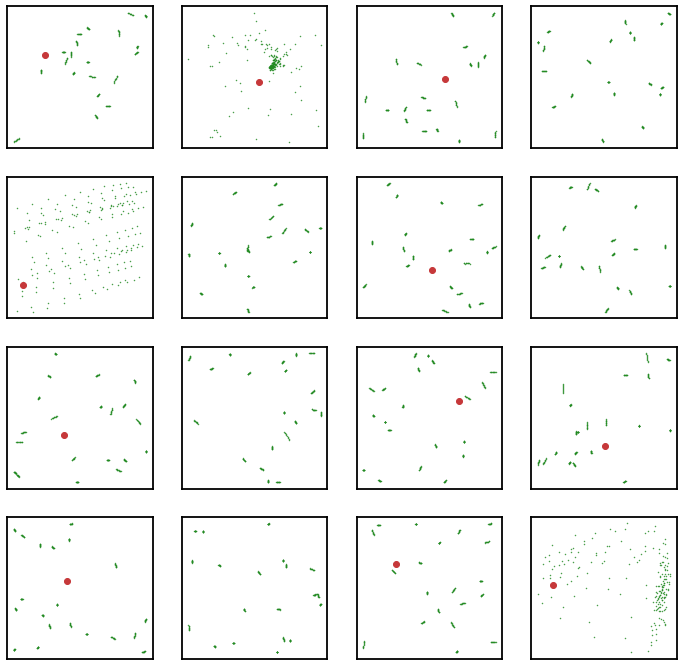

In [9]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 12))

gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])

    for x_i in x[i]:
        ax.scatter(x_i.T[0], x_i.T[1], color='forestgreen', s=0.2)
        
    if y[i]:
        ax.scatter(y_lens_pos[i,0], y_lens_pos[i,1], label="Lens position")
        
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
#     ax.legend()
    

## Normalize data

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [11]:
from einops import rearrange

In [12]:
x = torch.Tensor(x)
y = torch.Tensor(y)

In [13]:
# Normalize and rotate data

x = x - x[:, :, 0, :].unsqueeze(-2)  # Set first position to zero

In [14]:
theta = torch.atan2(x[:, :, -1, 0], x[:, :, -1, 1]).numpy()  # Get rotation angle
rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])  # Get rotation matrix
rot = torch.Tensor(rearrange(rot, 'i j k l  -> k l i j'))
rot = torch.repeat_interleave(rot.unsqueeze(-3), 10, -3)

In [15]:
rot.shape, x.shape

(torch.Size([20000, 20, 10, 2, 2]), torch.Size([20000, 20, 10, 2]))

In [16]:
x = torch.einsum('ijkmn, ijkn -> ijkm', rot, x)

  0%|          | 0/16 [00:00<?, ?it/s]

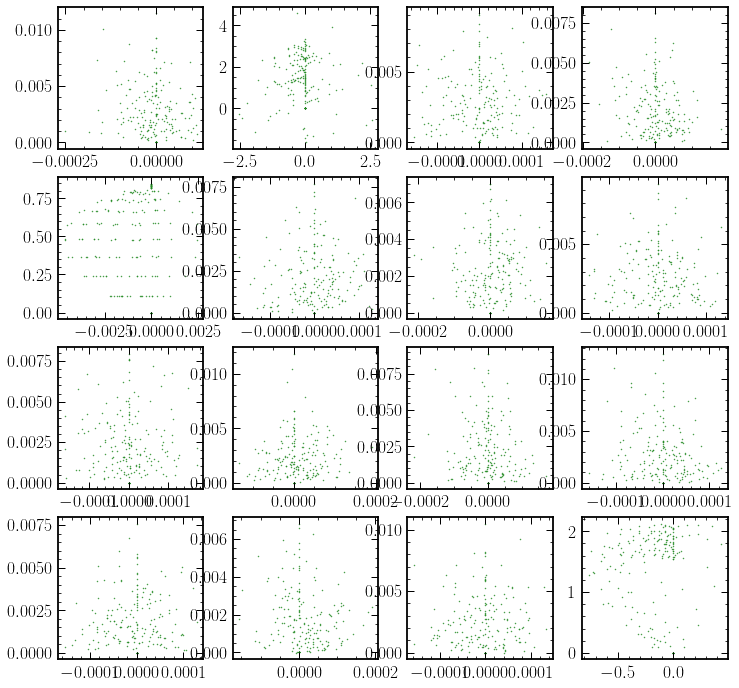

In [17]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 12))

gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])

    for x_i in x[i]:
        ax.scatter(x_i.T[0], x_i.T[1], color='forestgreen', s=0.2)    

# Time-series deep set model

In [18]:
def build_mlp(input_dim, hidden_dim, output_dim, layers):
    """Create an MLP from the configurations
    """
    activation = nn.ReLU

    seq = [nn.Linear(input_dim, hidden_dim), activation()]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation()]
    seq += [nn.Linear(hidden_dim, output_dim)]

    return nn.Sequential(*seq)

In [19]:
class DeepSetLSTM(nn.Module):
    def __init__(self, hidden_dim=64, output_dim=1):
        """ A deep set model based on an LSTM encoder
        """
        super(DeepSetLSTM, self).__init__()
                    
        # Bi-dirctional LSTM encoder
        self.phi = nn.LSTM(input_size=2, hidden_size=hidden_dim, num_layers=8, batch_first=True, bidirectional=True)
        self.phi_mlp = build_mlp(input_dim=2 * hidden_dim, hidden_dim=4 * hidden_dim, output_dim=output_dim, layers=4)
        
        # MLP post-aggregation network
        self.rho = build_mlp(input_dim=2 * hidden_dim, hidden_dim=2 * hidden_dim, output_dim=output_dim, layers=4)

    def forward(self, x):
        
        batch_size = x.shape[0]
        
        # Combine batch and number of stars into a single 'batch' dimension
        x = rearrange(x, 'b s t xy -> (b s) t xy')
        
        # Encode all through LSTM
        x, (h, c) = self.phi(x) 
        
        # Extract two 'hidden' vectors corresponding to two directions in LSTM
        h = rearrange(h, '(d l) b h -> b d l h', d=2)[:, :, -1, :]
        h = rearrange(h, 'b d h -> b (d h)')
        
        # Uncombine batch and star dimensions, then do mean-aggregation along star axis
        # (Enforce permutation invariance)
        h = rearrange(h, '(b s) h -> b s h', b=batch_size).mean(-2)
        
        x = self.phi_mlp(x)
        
        # Pass through post-aggregation network
        x = self.rho(h).squeeze(-1)
        
        return x

In [20]:
import sys
sys.path.append("../")

from models.flows import build_maf

In [21]:
from torch.utils.data import TensorDataset, DataLoader, random_split, SubsetRandomSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping

In [22]:
# Standardize input data by Z-scoring
x = (x - x.mean().mean(0)) / x.std(0).std(0)
x[:, :, 0, :] = 0.

# Classification

In [23]:
val_fraction = 0.1
n_samples_val = int(val_fraction * len(x))

dataset = TensorDataset(x, y)

dataset_train, dataset_val = random_split(dataset, [len(x) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=64, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=64, num_workers=8, pin_memory=True, shuffle=False)

/n/home11/smsharma/.conda/envs/deepsets/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
class MultiBlipClassifier(pl.LightningModule):

    def __init__(self):
        """ Lightning module
        """
        super().__init__()
        self.deepset = DeepSetLSTM()

    def configure_optimizers(self):
        
        optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4)
        
        return {"optimizer": optimizer, 
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 1}
                }
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.deepset(x)
        loss = nn.BCEWithLogitsLoss(reduction='mean')(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.deepset(x)
        loss = nn.BCEWithLogitsLoss(reduction='mean')(y_hat, y)
        self.log('val_loss', loss)

In [25]:
model = MultiBlipClassifier()

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
early_stop_callback = EarlyStopping(monitor='val_loss', patience=8)        
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(max_epochs=25, gpus=1, gradient_clip_val=1., callbacks=[checkpoint_callback, early_stop_callback, lr_monitor])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
model.load_from_checkpoint(checkpoint_callback.best_model_path);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name    | Type        | Params
----------------------------------------
0 | deepset | DeepSetLSTM | 1.1 M 
----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.437     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluate classification performance

In [664]:
model.to('cuda')
model.eval()

y_hat = []
y_val = []
for batch in tqdm(val_loader):
    x_batch, y_batch = batch
    y_hat.append(torch.sigmoid(model.deepset(x_batch.to('cuda'))).to('cpu').detach().numpy())
    y_val.append(y_batch)

  0%|          | 0/32 [00:00<?, ?it/s]

In [665]:
y_hat = np.concatenate(y_hat)
y_test = np.concatenate(y_val)

In [666]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

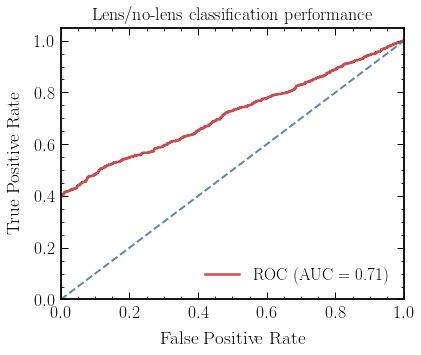

In [667]:
plt.plot(fpr, tpr, label="ROC (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Lens/no-lens classification performance")
plt.legend(loc="lower right")
plt.show()

# Inference

In [668]:
y_lens_prop_mean = y_lens_prop.mean(-2)
y_lens_prop_std = y_lens_prop.std(-2)

y_lens_prop = (y_lens_prop - y_lens_prop_mean) / y_lens_prop_std

In [669]:
y_lens_prop = torch.Tensor(y_lens_prop)

In [670]:
val_fraction = 0.1
n_samples_val = int(val_fraction * len(x))

dataset = TensorDataset(x, y, y_lens_prop)

dataset_train, dataset_val = random_split(dataset, [len(x) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=128, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=128, num_workers=8, pin_memory=True, shuffle=False)

/n/home11/smsharma/.conda/envs/deepsets/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [674]:
class MultiBlipInference(pl.LightningModule):

    def __init__(self, output_dim=128):
        """ Lightning module
        """
        super().__init__()
        self.deepset = DeepSetLSTM(hidden_dim=64, output_dim=128)
        self.flow = build_maf(dim=2, num_transforms=8, context_features=64, hidden_features=128)
        self.mlp_y_hat = build_mlp(input_dim=64, hidden_dim=128, output_dim=1, layers=4)
        self.mlp_post = build_mlp(input_dim=64, hidden_dim=128, output_dim=64, layers=4)

    def configure_optimizers(self):
        
        optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4)
        
        return {"optimizer": optimizer, 
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 1}
                }
    
    def training_step(self, batch, batch_idx):
        x, y, y_lens = batch
        
        out = self.deepset(x)
        
        out_post, out_y_hat = torch.chunk(out, 2, -1)
        out_post = self.mlp_post(out_post)
        y_hat = self.mlp_y_hat(out_y_hat)[:, 0]
        
        loss_class = nn.BCEWithLogitsLoss()(y_hat, y).mean()
        loss_post = -self.flow.log_prob(y_lens[y == 1.], context=out_post[y == 1.]).mean()

        loss = loss_post + loss_class

        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, y_lens = batch
        
        out = self.deepset(x)
        out_post, out_y_hat = torch.chunk(out, 2, -1)
        out_post = self.mlp_post(out_post)
        y_hat = self.mlp_y_hat(out_y_hat)[:, 0]
            
        loss_class = nn.BCEWithLogitsLoss()(y_hat, y).mean()
        loss_post = -self.flow.log_prob(y_lens[y == 1.], context=out_post[y == 1.]).mean()
        
        loss = loss_post + loss_class

        self.log('val_loss', loss)
        return loss


In [675]:
model = MultiBlipInference()

In [676]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
early_stop_callback = EarlyStopping(monitor='val_loss', patience=8)        
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(max_epochs=50, gpus=1, gradient_clip_val=1., callbacks=[checkpoint_callback, early_stop_callback, lr_monitor])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
model.load_from_checkpoint(checkpoint_callback.best_model_path);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type        | Params
------------------------------------------
0 | deepset   | DeepSetLSTM | 1.2 M 
1 | flow      | Flow        | 342 K 
2 | mlp_y_hat | Sequential  | 74.5 K
3 | mlp_post  | Sequential  | 82.6 K
------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.630     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluate

In [677]:
model.to('cuda');
model.eval();

In [678]:
y_hat = []
y_val = []
for batch in tqdm(val_loader):
    x_batch, y_batch, y_lens_batch = batch
    out_batch = model.deepset(x_batch.to('cuda'))
    y_hat.append(torch.sigmoid(model.mlp_y_hat(torch.chunk(out_batch, 2, -1)[-1])).to('cpu').detach().numpy())
    y_val.append(y_batch)

  0%|          | 0/16 [00:00<?, ?it/s]

In [679]:
y_hat = np.concatenate(y_hat)
y_test = np.concatenate(y_val)

In [680]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

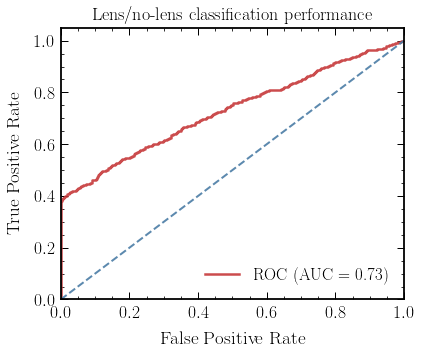

In [681]:
plt.plot(fpr, tpr, label="ROC (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Lens/no-lens classification performance")
plt.legend(loc="lower right")
plt.show()

In [682]:
import corner

In [683]:
def destandardize(samples):
    return samples * y_lens_prop_std + y_lens_prop_mean

In [687]:
! pip install getdist

     |████████████████████████████████| 777 kB 3.6 MB/s eta 0:00:01
  Created wheel for getdist: filename=GetDist-1.3.4-py3-none-any.whl size=226496 sha256=c6fd7ca63255c094ba570cf3d0d259feb5668e8c27d9f169ef093297efb8a95d
  Stored in directory: /n/home11/smsharma/.cache/pip/wheels/b9/3f/f3/e930f27749418f87faa6014a7b3ba8537736458c503d728730
Successfully built getdist


In [688]:
from getdist import plots, MCSamples

In [722]:
import seaborn as sns

0it [00:00, ?it/s]

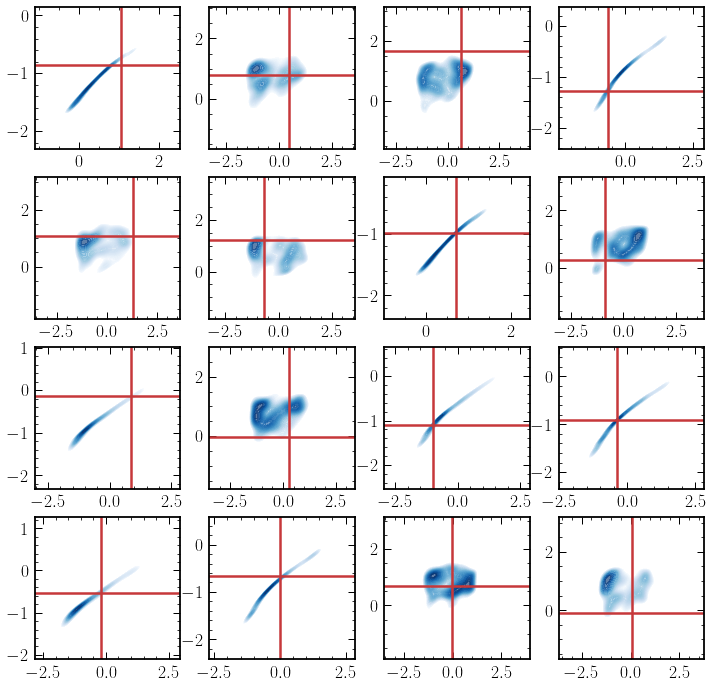

In [723]:
fig = plt.figure(figsize=(12, 12))

gs = GridSpec(4, 4)

for ii, i in tqdm(enumerate(range(16, 16 + 16))):
    
    ax = fig.add_subplot(gs[ii])
    
    idx = torch.where(y == 1)[0][i].numpy()
    context = model.mlp_post(torch.chunk(model.deepset(x[idx].unsqueeze(0).to('cuda')), 2, -1)[0])
    samples, log_prob = model.flow.sample_and_log_prob(num_samples=5000, context=context)

    samps = np.nan_to_num(samples.cpu().detach().numpy()[0]).T
    
    sns.kdeplot(x=samps[0], y=samps[1], fill=True, levels=50, cmap=sns.color_palette("Blues", as_cmap=True), thresh=0.5, alpha=0.65, ax=ax)
    
    ax.axvline(y_lens_prop[idx].numpy()[0])
    ax.axhline(y_lens_prop[idx].numpy()[1])
    

/n/home11/smsharma/.conda/envs/deepsets/lib/python3.9/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


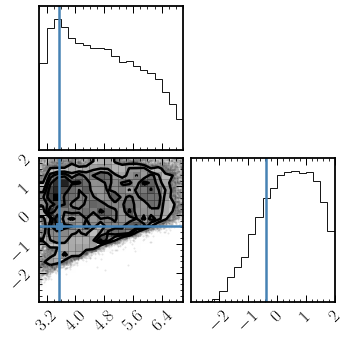

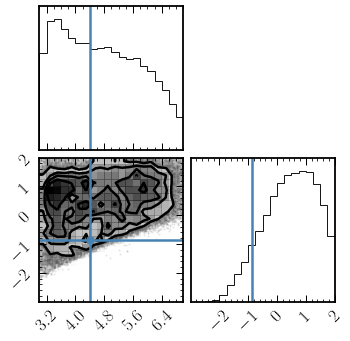

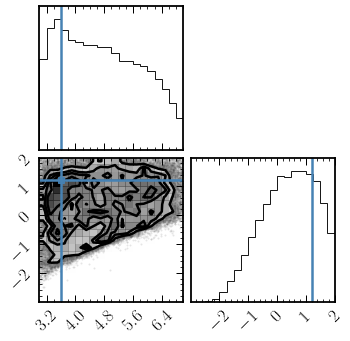

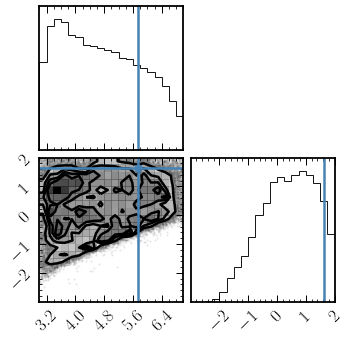

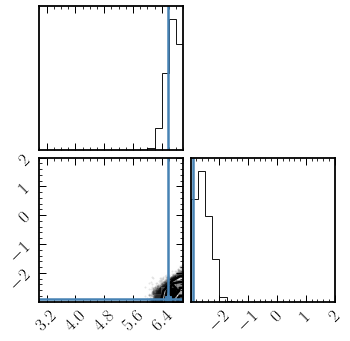

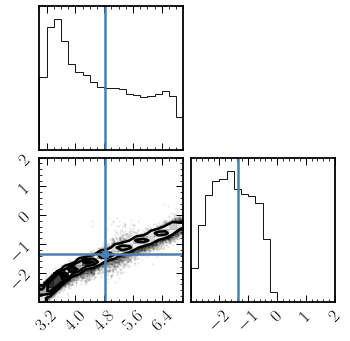

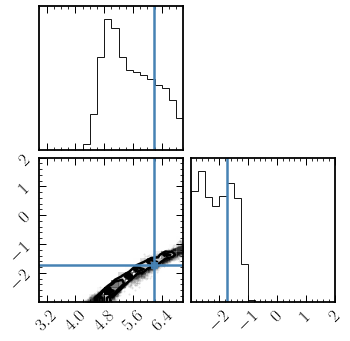

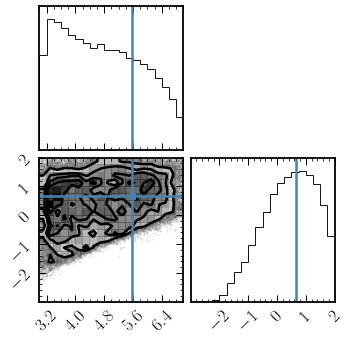

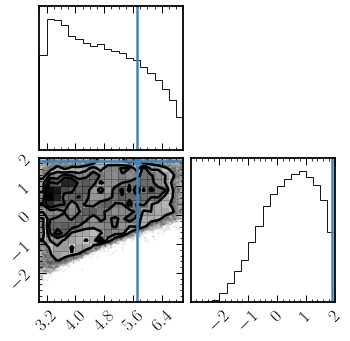

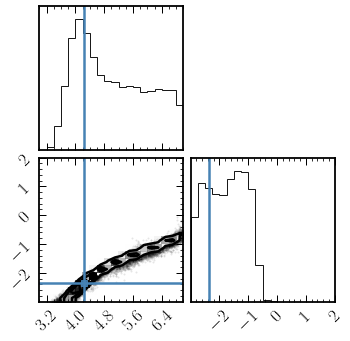

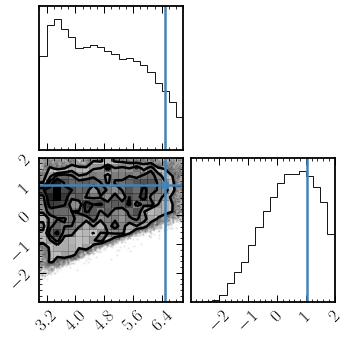

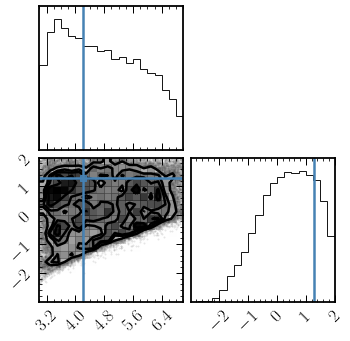

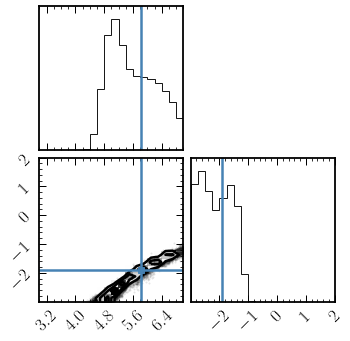

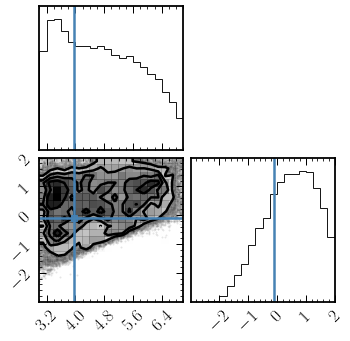

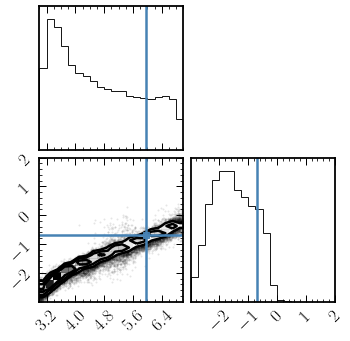

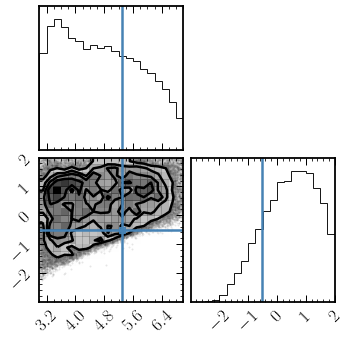

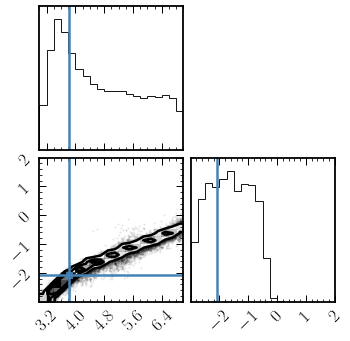

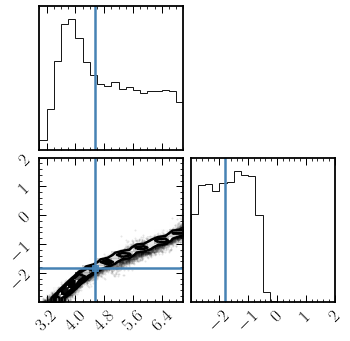

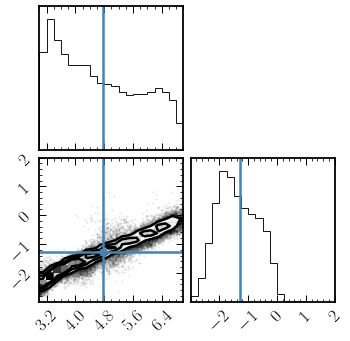

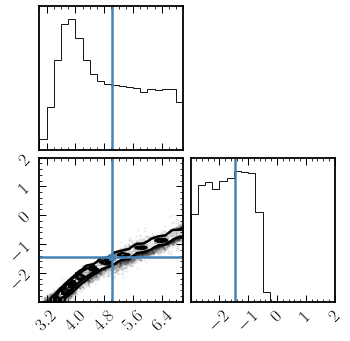

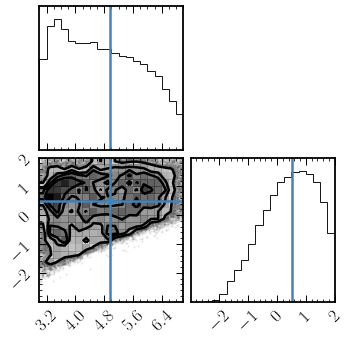

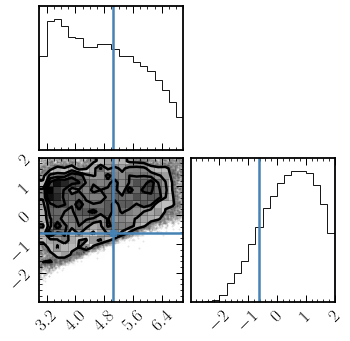

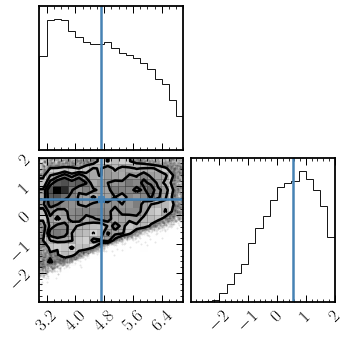

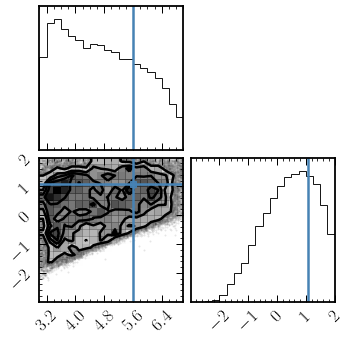

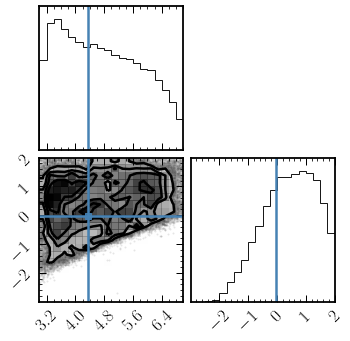

In [685]:
for i in range(10, 35):

    idx = torch.where(y == 1)[0][i].numpy()
    context = model.mlp_post(torch.chunk(model.deepset(x[idx].unsqueeze(0).to('cuda')), 2, -1)[0])
    samples, log_prob = model.flow.sample_and_log_prob(num_samples=50000, context=context)
    corner.corner(destandardize(samples.cpu().detach().numpy()[0]) , truths=destandardize(y_lens_prop[idx].numpy()), range=[[3,7],[-3,2]]);
    